In [1]:
import numpy as np
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.simulator import (
    SimulationConfig,
    PanelSimulator,
    FactorDGP,
)
from synthlearners.plotting import SynthPlotter

## Basic use with Panel Matrices

In [2]:
config = SimulationConfig(
    N=100,
    T=50,
    T_pre=40,
    n_treated=10,
    selection_mean=1.0,
    treatment_effect=0.5,
    dgp=FactorDGP(K=2, sigma=1, time_fac_lb=-0.1, time_fac_ub=0.1, trend_sigma=0.0001),
)
simulator = PanelSimulator(config)
Y, Y_0, L, treated_units = simulator.simulate()

In [3]:
treated_units

array([89, 32, 13, 80, 85, 28, 82, 45,  9, 64])

In [4]:
from synthlearners.mcnnm import MatrixCompletionEstimator

In [5]:
# Create a mask indicating which entries are observed.
mask = np.ones_like(Y)
missing_periods = config.T-config.T_pre

# For treated units, suppose the outcomes in the last N periods are missing.
mask[treated_units, -missing_periods:] = 0

In [6]:
mask[treated_units[0]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
estimator = MatrixCompletionEstimator(
    lambda_param=2e-3,
    max_iter=500,
    tol=1e-6,
    verbose=True
)
estimator.fit(Y, mask)
Y_completed = estimator.completed_matrix_

shrink_treshhold: 4.9
Iteration   1, relative change = 4113061563.945353
Iteration   2, relative change = 0.021431
Iteration   3, relative change = 0.011845
Iteration   4, relative change = 0.006759
Iteration   5, relative change = 0.003950
Iteration   6, relative change = 0.002351
Iteration   7, relative change = 0.001421
Iteration   8, relative change = 0.000870
Iteration   9, relative change = 0.000539
Iteration  10, relative change = 0.000337
Iteration  11, relative change = 0.000213
Iteration  12, relative change = 0.000136
Iteration  13, relative change = 0.000088
Iteration  14, relative change = 0.000057
Iteration  15, relative change = 0.000037
Iteration  16, relative change = 0.000024
Iteration  17, relative change = 0.000016
Iteration  18, relative change = 0.000011
Iteration  19, relative change = 0.000007
Iteration  20, relative change = 0.000005
Iteration  21, relative change = 0.000003
Iteration  22, relative change = 0.000002
Iteration  23, relative change = 0.000001
Ite

In [8]:
# Counterfactual Values for imputed periods for single treated example
Y_0[treated_units[0], -missing_periods:]

array([-0.76488391, -0.15174888, -0.13119737,  0.30966483,  0.12721515,
        0.81209996,  0.97510635, -1.01615275,  0.85462799, -1.3490142 ])

In [9]:
# Observed Value for imputed periods from single treated example
Y[treated_units[0], -missing_periods:]

array([-0.26488391,  0.34825112,  0.36880263,  0.80966483,  0.62721515,
        1.31209996,  1.47510635, -0.51615275,  1.35462799, -0.8490142 ])

In [10]:
# MC Values for imputed periods for single treated example
Y_completed[treated_units[0], -missing_periods:]

array([ 0.12295758, -0.22432011, -0.322544  ,  0.3633754 ,  0.34699387,
        0.24513517,  0.00243552, -0.36594639,  0.26558588, -0.56419653])

In [11]:
baseline_bias = (
    Y_completed[treated_units[0], -missing_periods:]
    - Y_0[treated_units[0], -missing_periods:]
)
print(
    "Baseline Bias of MC value relative to actual counterfactual",
    np.mean(baseline_bias),
)

Baseline Bias of MC value relative to actual counterfactual 0.02037592140397827


In [12]:
te = (
    Y[treated_units[0], -missing_periods:]
    - Y_completed[treated_units[0], -missing_periods:]
)
print("Estimated Treatment Effect of Observed relative to MC Value", np.mean(te))

Estimated Treatment Effect of Observed relative to MC Value 0.4796240785960217


In [13]:
print("Treatment Effect Bias", np.abs(np.mean(te) - config.treatment_effect))

Treatment Effect Bias 0.020375921403978314


In [14]:
estimator2 = MatrixCompletionEstimator(
    lambda_param=1e-3, max_iter=500, tol=1e-10, verbose=True
)
# Try approach with fixed effects
estimator2.fit(Y, mask, unit_intercept=True, time_intercept=True)
Y_completed2 = estimator2.completed_matrix_

shrink_treshhold: 2.45
lambda_L_max: 0.007299648031903809
shrink_treshhold_max: 17.884137678164333
Terminated at iteration: 35, for lambda_L: 0.001, with obj_val: 0.39585203777809574
Final Singular Values ((50,)): [15.55587754 13.87581394 13.65486849 12.14563752 11.92455459 11.550706
 11.40942175 11.19989068 10.93334074 10.56967262 10.2817019   9.73915737
  9.63158719  9.2517932   9.09727478  8.80991282  8.48441453  8.27157669
  8.05972594  7.8240482   7.75611987  7.54727866  6.94348512  6.82600822
  6.70772705  6.57615179  6.22834272  6.13291749  5.91206673  5.62734862
  5.41433617  5.13189686  4.76389823  4.52090653  4.32756971  4.18955531
  3.6389489   3.39034692  3.20087445  3.01629238  2.78444583  2.46104966
  2.32644538  1.98000701  1.74957944  1.64085671  1.38517516  0.76552029
  0.61091007  0.        ]
unit FE ((100,)): [ 0.1009985   0.07896732 -0.09641629 -0.22327642 -0.05426182  0.26054295
 -0.1864726  -0.09672387  0.02568004  0.11458629  0.13750042  0.41055008
 -0.03696323  

In [15]:
# MC Values for imputed periods for single treated example
Y_completed2[treated_units[0], -missing_periods:]

array([-0.28757005, -0.41549916, -0.33844419,  0.0254634 , -0.0309409 ,
        0.28034689,  0.11904477, -0.4844724 ,  0.47328732, -0.89789453])

In [16]:
baseline_bias2 = (
    Y_completed2[treated_units[0], -missing_periods:]
    - Y_0[treated_units[0], -missing_periods:]
)
print(
    "Baseline Bias of MC value relative to actual counterfactual",
    np.mean(baseline_bias2),
)

Baseline Bias of MC value relative to actual counterfactual -0.12223960115653329


In [17]:
te2 = (
    Y[treated_units[0], -missing_periods:]
    - Y_completed2[treated_units[0], -missing_periods:]
)
print("Estimated Treatment Effect of Observed relative to MC Value", np.mean(te2))

Estimated Treatment Effect of Observed relative to MC Value 0.6222396011565332


In [18]:
print("Treatment Effect Bias", np.abs(np.mean(te2) - config.treatment_effect))

Treatment Effect Bias 0.1222396011565332


## Use with workhorse `Synth` class

### Simulation with multiple Treatment Units

In [32]:
config = SimulationConfig(
    N=100,
    T=50,
    T_pre=40,
    n_treated=10,
    selection_mean=1.0,
    treatment_effect=0.5,
    dgp=FactorDGP(K=2, sigma=1, time_fac_lb=-0.1, time_fac_ub=0.1, trend_sigma=0.0001),
)
simulator = PanelSimulator(config)
Y, Y_0, L, treated_units = simulator.simulate()

Computing jackknife estimates:   0%|          | 0/100 [00:00<?, ?it/s]

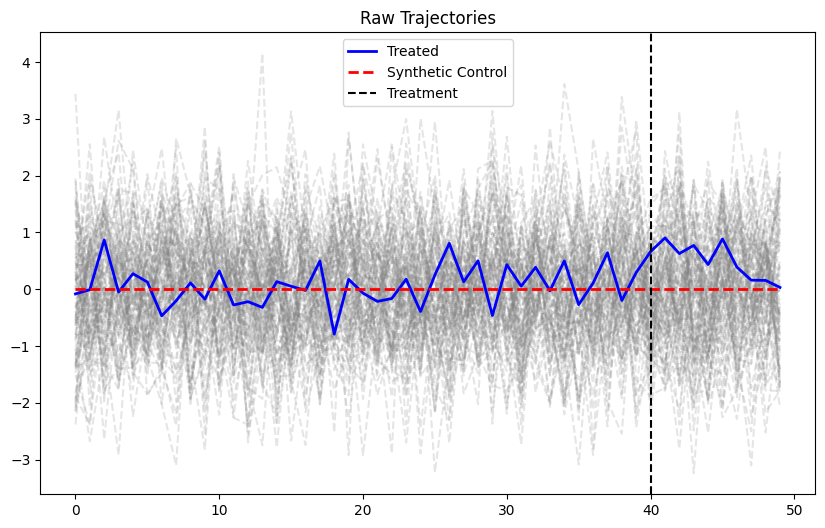

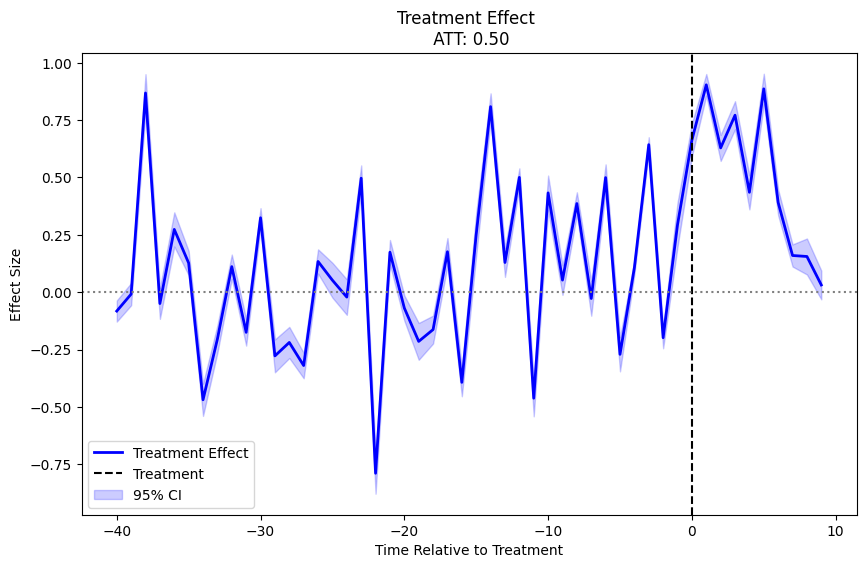

In [33]:
synth = Synth(
    method="matrix_completion",
    n_jobs=-1,
)
results = synth.fit(
    Y,
    treated_units,
    config.T_pre,
    compute_jackknife=True,
)
# Plot raw data
synth.plot(results, Y, treated_units, config.T_pre, mode="raw")
plt.show()
synth.plot(results, Y, treated_units, config.T_pre, mode="effect", show_ci=True)
plt.show()

### ADH Application

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.utils import prepare_panel

In [20]:
adh_data = pd.read_csv("ADH2015.csv", index_col=0)
adh_data = adh_data[["country", "year", "gdp"]]
# manually create treatment indicator
adh_data["treat"] = np.where(
    (adh_data.country == "West Germany") & (adh_data.year > 1990), 1, 0
)
adh_data.head()

,country,year,gdp,treat
index,,,,
1.0,USA,1960.0,2879,0
1.0,USA,1961.0,2929,0
1.0,USA,1962.0,3103,0
1.0,USA,1963.0,3227,0
1.0,USA,1964.0,3420,0


In [21]:
data = prepare_panel(
    adh_data,
    unit_col="country",
    time_col="year",
    outcome_col="gdp",
    treatment_col="treat",
)

Text(0.5, 1.0, 'Treatment matrix')

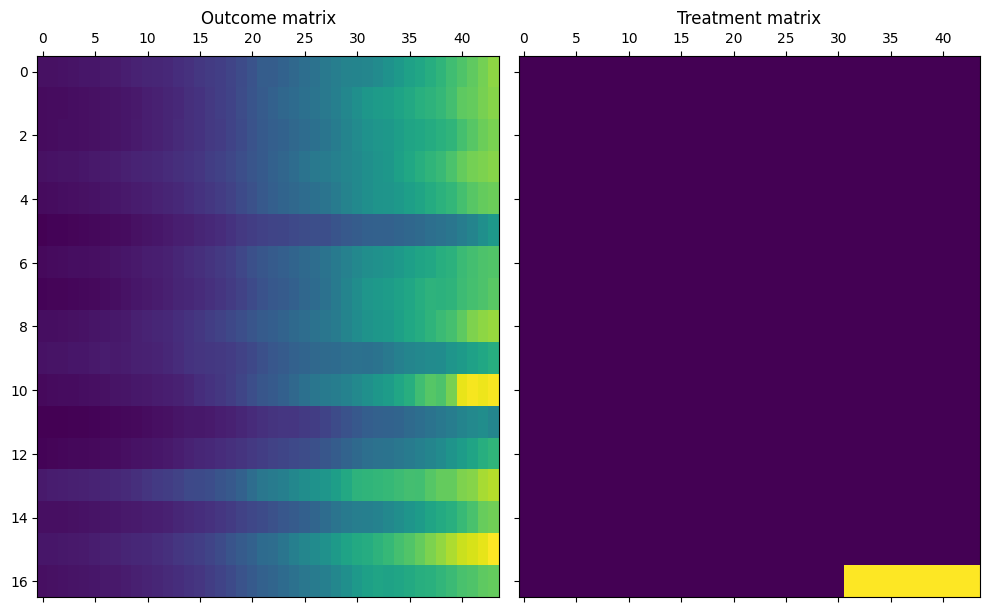

In [22]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax[0].matshow(data["Y"], aspect="auto", cmap="viridis")
ax[1].matshow(data["W"], aspect="auto", cmap="viridis")
f.tight_layout()
ax[0].set_title("Outcome matrix")
ax[1].set_title("Treatment matrix")

In [23]:
# Fit synthetic control - basic
synth = Synth(method="simplex")
results = synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
)

You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

In [24]:
# Fit synthetic control
mc_synth = Synth(method="matrix_completion")
mc_results = mc_synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
    verbose=False
)

You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

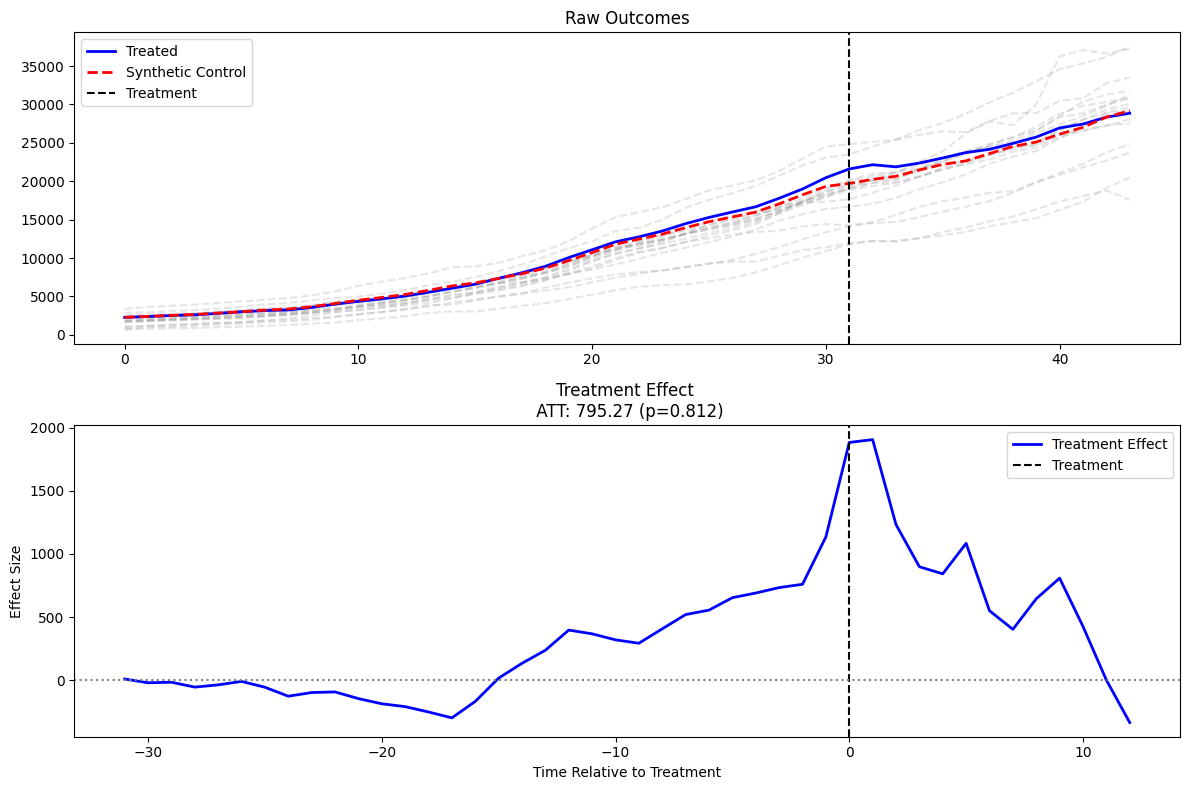

In [25]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
mc_synth.plot(mc_results, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
mc_synth.plot(
    mc_results,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

In [24]:
# Fit synthetic control
mc_synth2 = Synth(method="matrix_completion", unit_intercept=True, time_intercept=True)
mc_results2 = mc_synth2.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
    verbose=True,
)

shrink_treshhold: 3675.0
lambda_L_max: 114.67839133399059
shrink_treshhold_max: 42144.308815241544
Terminated at iteration: 37, for lambda_L: 10.0, with obj_val: 618537.5624815561
Final Singular Values ((17,)): [38736.44508387 10133.12334564  2455.12618651     0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.        ]
unit FE ((17,)): [13386.54058682 12555.82070319 12730.53814861 12320.20388144
 13023.52019603 12241.3423653   7833.52911424 11801.25381112
 11792.15517187 12887.26762452 10428.62755992 13323.19763625
  7070.88861517  9026.1662671  15866.41704321 11349.8725644
 15717.2612931 ]
time FE ((44,)): [-10058.74132837  -9947.85897543  -9827.97662249  -9717.38838719
  -9561.03544602  -9405.85897543  -9218.03544602  -9067.32956366
  -8799.38838719  -8440.44721072  -8101.56485778  -7787.09426955
  -7429.91779896  -6934.97662249  -6428.91779896  -5977.03544602
  -540

Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

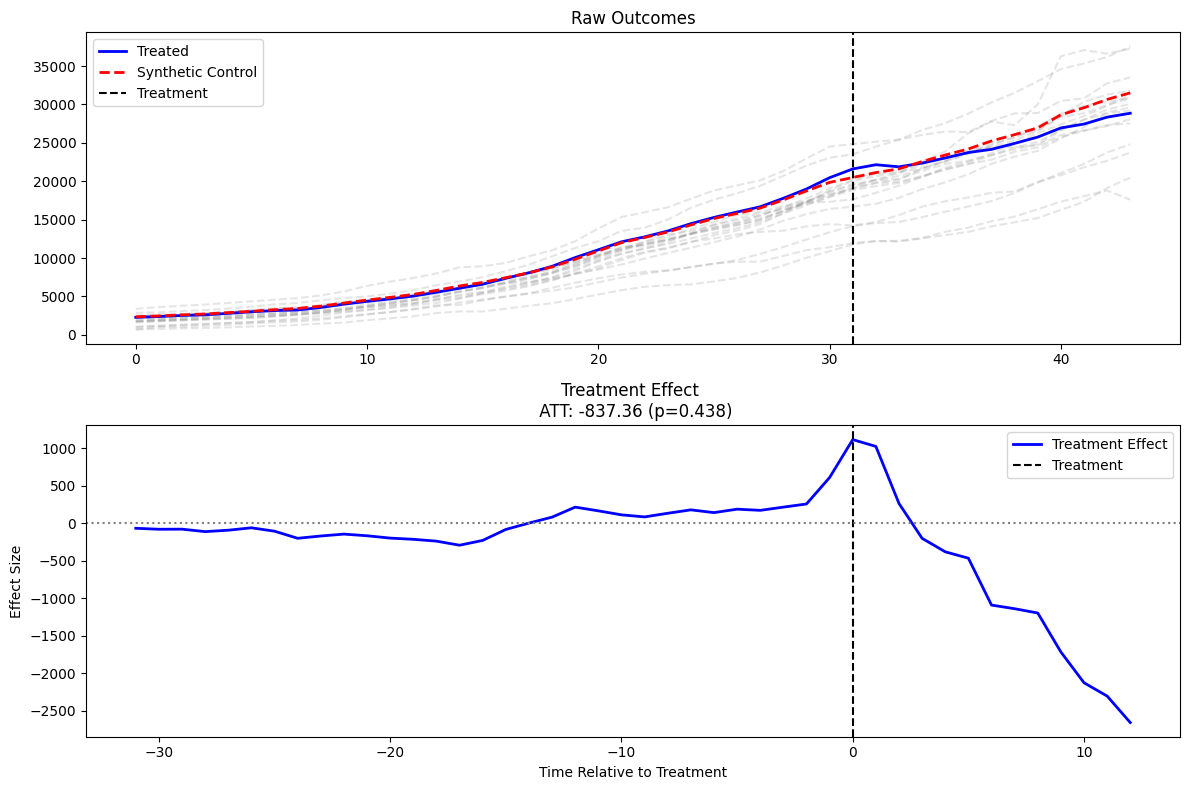

In [25]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
mc_synth2.plot(
    mc_results2, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1
)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
mc_synth2.plot(
    mc_results2,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

In [26]:
# Fit multiple synthetic controls
synth_methods = [
    Synth(method="lp_norm", p=1.0),
    Synth(method="lp_norm", p=2.0),
    Synth(method="linear"),
    Synth(method="simplex"),
    Synth(method="matrix_completion"),
    Synth(method="matrix_completion", unit_intercept=True, time_intercept=True),
]

results = [
    method.fit(
        data["Y"],
        data["treated_units"],
        data["T_pre"],
        compute_jackknife=False,
        verbose=False,
    )
    for method in synth_methods
]

Choosing regularization parameter using sequential cross-validation
Choosing regularization parameter using sequential cross-validation


In [27]:
from synthlearners.plotting import SynthPlotter

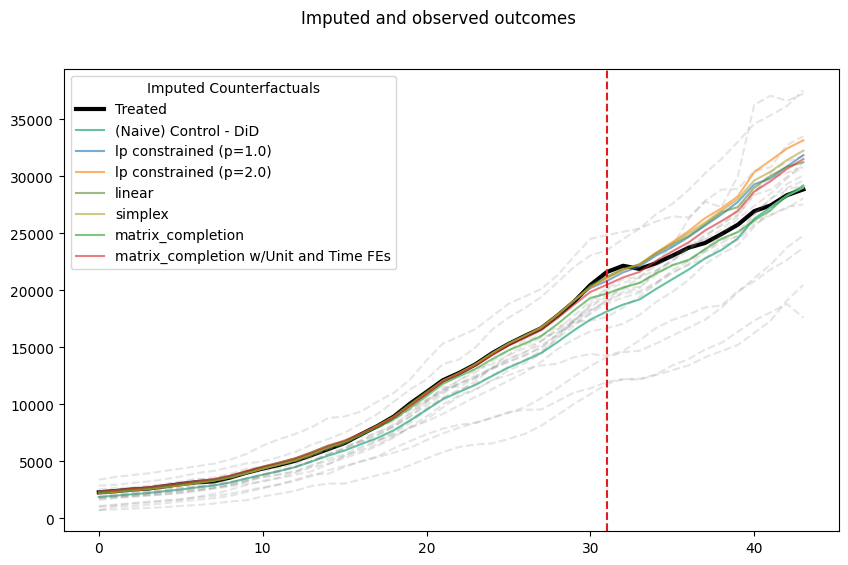

In [28]:
# Create plot
plotter = SynthPlotter()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_trajectories(
    results, data["Y"], data["treated_units"], data["T_pre"], ax=ax, show_controls=True
)
fig.suptitle("Imputed and observed outcomes")
plt.show()

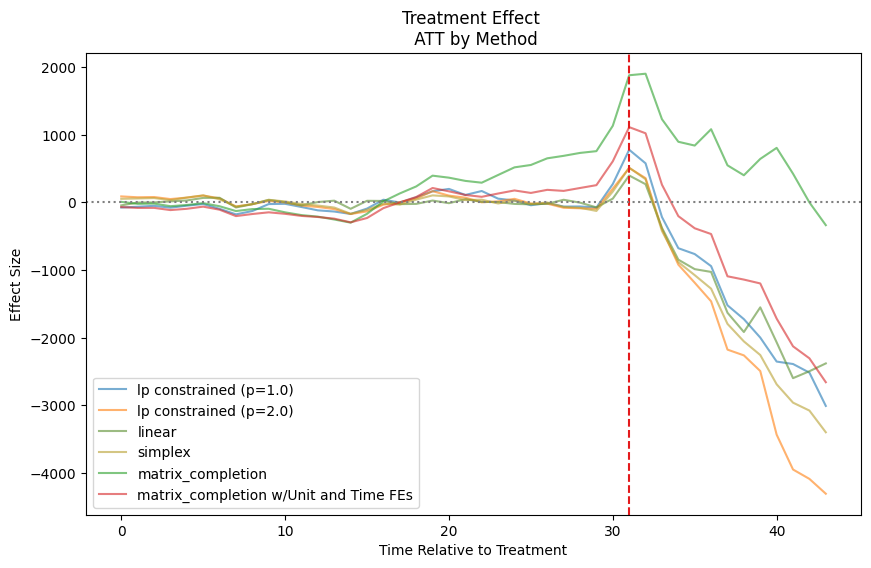

In [29]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_treatment_effects(results, data["T_pre"], ax=ax)
plt.show()

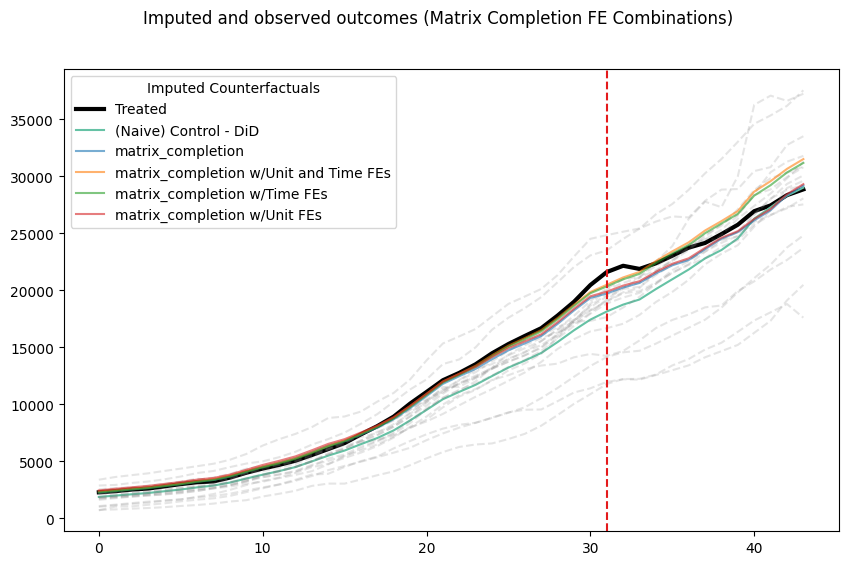

In [30]:
# Fit multiple synthetic controls
synth_methods2 = [
    Synth(method="matrix_completion"),
    Synth(method="matrix_completion", unit_intercept=True, time_intercept=True),
    Synth(method="matrix_completion", unit_intercept=False, time_intercept=True),
    Synth(method="matrix_completion", unit_intercept=True, time_intercept=False),
]

results2 = [
    method.fit(
        data["Y"],
        data["treated_units"],
        data["T_pre"],
        compute_jackknife=False,
        verbose=False,
    )
    for method in synth_methods2
]

# Create plot
plotter2 = SynthPlotter()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter2.plot_trajectories(
    results2, data["Y"], data["treated_units"], data["T_pre"], ax=ax, show_controls=True
)
fig.suptitle("Imputed and observed outcomes (Matrix Completion FE Combinations)")
plt.show()

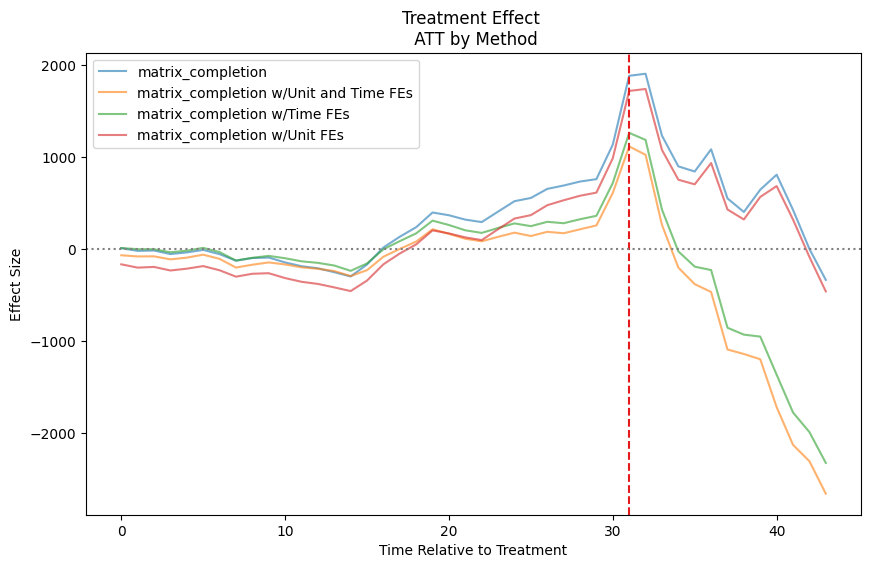

In [31]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter2.plot_treatment_effects(results2, data["T_pre"], ax=ax)
plt.show()

# NOTES:
- ADH: N = 17, T = 44
- MC w/Unit FE is similar to MC w/ NO FE
- MC w/Unit and Time FE is similar to MC w/Time FE
- MC w/Unit and Time FE more simliar to other Synthetic Control methods
- Likely makes sense given T > N
- MC relative to other methods fits less well in the periods leading up to the treatment time (over-estimates values)

Does this mean approach would have value from upweighting errors closer to the end of the panel?